# Import Library

In [3]:
# !pip install awswrangler -q

In [31]:
import awswrangler as wr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import json
import seaborn as sns

# Load Data

In [5]:
monitor_hist = wr.s3.read_csv('s3://dd-ai-ml/raw_data/preprocessing/parse_data.csv')

# EDA

In [6]:
## 형변환
monitor_hist['event_date_min'] = pd.to_datetime(monitor_hist['event_date_min'])

## 컬럼명 변경
monitor_hist.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(monitor_hist)]

In [7]:
## 데이터 개수 확인
monitor_hist.shape

(902910, 59)

## Split Train/Test Data

In [8]:
train_df = monitor_hist[:int(len(monitor_hist) * 0.8)]
test_df = monitor_hist[int(len(monitor_hist) * 0.8):]
print(f"trian_df : {train_df.shape}, {train_df['event_date_min'].min(), train_df['event_date_min'].max()}")
print(f"test_df : {test_df.shape}, {test_df['event_date_min'].min(), test_df['event_date_min'].max()}")

trian_df : (722328, 59), (Timestamp('2021-01-01 00:00:00'), Timestamp('2022-06-02 13:23:00'))
test_df : (180582, 59), (Timestamp('2022-06-02 13:24:00'), Timestamp('2022-10-06 00:00:00'))


## Check Single Value

In [9]:
single_col = []
for col in list(train_df):
    if train_df[col].nunique() <= 1:
        print(f'{col} single value : {train_df[col].unique()}')
        single_col.append(col)

gsm_key single value : [6345]
green_house_id single value : [6345000000001]
prd_code single value : [804.  nan]
dc_power_1 single value : [0]
dc_power_1_auto_manual_mode single value : [1]
ac_power_1 single value : [0]
ac_power_1_auto_manual_mode single value : [1]


## Check NaN Values

In [10]:
isna_col = []
isna_num = []
for col in list(train_df):
    if train_df[col].isna().sum() > 0:
        print(f'{col} NaN : {train_df[col].isna().sum()}')
        isna_col.append(col)
        isna_num.append(train_df[col].isna().sum())

prd_code NaN : 19417
crops_start_date NaN : 19417
crops_end_date NaN : 19417
sensor_inner_temperature1_1 NaN : 6150
sensor_inner_hum1_1 NaN : 6150
sensor_plantation_temperature_1_1 NaN : 6151
sensor_plantation_hum_1_1 NaN : 6151
sensor_inner_co2_1 NaN : 6156
sensor_inner_temperature1_2 NaN : 6145
sensor_inner_hum1_2 NaN : 7498
sensor_plantation_temperature_1_2 NaN : 6145
sensor_plantation_hum_1_2 NaN : 6145
sensor_inner_co2_2 NaN : 6145
sensor_rain_1 NaN : 6121
sensor_outer_light_1 NaN : 6121
sensor_outer_hum_1 NaN : 6121
sensor_outer_temperature_1 NaN : 6121
sensor_wind_speed_1 NaN : 46324
sensor_wind_direction_1 NaN : 6121
v_sensor_group_temp_1 NaN : 6151
v_sensor_group_hum_1 NaN : 6151


In [11]:
## 같은 NaN 개수를 갖는 컬럼은 모두 동일한 위치에서 NaN값 발생
for num in set(isna_num):
    print(num)
    temp_col = []
    for col in list(train_df):
        if train_df[col].isna().sum() == num:
            temp_col.append(col)
    print(f"same NaN number col : {temp_col}")

    for idx in range(1, len(temp_col)):
        print(train_df[temp_col[0]].isna().equals(train_df[temp_col[idx]].isna()))

6145
same NaN number col : ['sensor_inner_temperature1_2', 'sensor_plantation_temperature_1_2', 'sensor_plantation_hum_1_2', 'sensor_inner_co2_2']
True
True
True
6150
same NaN number col : ['sensor_inner_temperature1_1', 'sensor_inner_hum1_1']
True
6151
same NaN number col : ['sensor_plantation_temperature_1_1', 'sensor_plantation_hum_1_1', 'v_sensor_group_temp_1', 'v_sensor_group_hum_1']
True
True
True
6121
same NaN number col : ['sensor_rain_1', 'sensor_outer_light_1', 'sensor_outer_hum_1', 'sensor_outer_temperature_1', 'sensor_wind_direction_1']
True
True
True
True
7498
same NaN number col : ['sensor_inner_hum1_2']
6156
same NaN number col : ['sensor_inner_co2_1']
46324
same NaN number col : ['sensor_wind_speed_1']
19417
same NaN number col : ['prd_code', 'crops_start_date', 'crops_end_date']
True
True


In [12]:
nan_idx = train_df[train_df['sensor_wind_speed_1'].isna()].index.tolist()
for col in list(train_df):
    if train_df[train_df[col].isna()].shape[0]>0:
        nan_idx = set(nan_idx) & set(train_df[train_df[col].isna()].index.tolist())

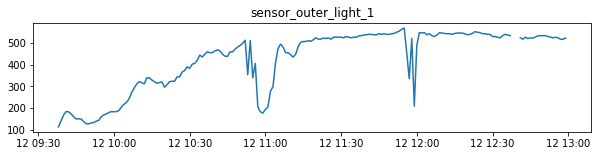

In [13]:
## 결측치 관련 추세 파악 그래프
for col in ['sensor_outer_light_1']:
    temp_df = train_df[[col, 'event_date_min']][16400:16600]
    temp_df.set_index('event_date_min', inplace = True)
    plt.figure(figsize = (10,2))
    plt.plot(temp_df[col])
    plt.title(col)
    plt.show()

## Check Outlier (Box_plot)

In [14]:
## Box plot columns 선정 (단일값, 카테고리형 변수 제거)
category_col = ['day_night', 'sensor_rain_1',
                'top_window_1', 'top_window_1_run_status', 'top_window_1_auto_manual_mode', 
                'top_window_2', 'top_window_2_run_status', 'top_window_2_auto_manual_mode',
                'side_window_1', 'side_window_1_run_status', 'side_window_1_auto_manual_mode',
                'side_window_2', 'side_window_2_run_status', 'side_window_2_auto_manual_mode',
                'dc_power_1_run_status', 'ac_power_1_run_status',
                'heat_cover_1', 'heat_cover_1_run_status', 'heat_cover_1_auto_manual_mode',
                'heat_cover_2', 'heat_cover_2_run_status', 'heat_cover_2_auto_manual_mode',
                'float_fan_1', 'float_fan_1_run_status', 'float_fan_1_auto_manual_mode',
                'exhaust_fan_1', 'exhaust_fan_1_run_status', 'exhaust_fan_1_auto_manual_mode',
               ]

box_plot_col = [col for col in list(train_df.select_dtypes(include = ['float', 'int'])) if (col not in single_col) & (col not in category_col)]

In [15]:
## Box plot columns 고유값 개수 확인
for col in box_plot_col:
    print(f'{col} nunique : {train_df[col].nunique()}')

sensor_inner_temperature1_1 nunique : 653
sensor_inner_hum1_1 nunique : 83
sensor_plantation_temperature_1_1 nunique : 544
sensor_plantation_hum_1_1 nunique : 41
sensor_inner_co2_1 nunique : 1577
sensor_inner_temperature1_2 nunique : 631
sensor_inner_hum1_2 nunique : 78
sensor_plantation_temperature_1_2 nunique : 497
sensor_plantation_hum_1_2 nunique : 51
sensor_inner_co2_2 nunique : 1558
sensor_outer_light_1_total_m nunique : 52188
sensor_outer_light_1_total_h nunique : 278655
sensor_outer_light_1_total_d nunique : 337193
sensor_outer_light_1 nunique : 671
sensor_outer_hum_1 nunique : 80
sensor_outer_temperature_1 nunique : 865
sensor_wind_speed_1 nunique : 574
sensor_wind_direction_1 nunique : 133
v_sensor_group_temp_1 nunique : 582
v_sensor_group_hum_1 nunique : 153


In [16]:
limit_100 = [col for col in box_plot_col if train_df[col].max() <= 100]
limit_1000 = [col for col in box_plot_col if (train_df[col].max() <= 1000) & (col not in limit_100)]
limit_10000 = [col for col in box_plot_col if (train_df[col].max() <= 10000) & (col not in limit_100) & (col not in limit_1000)]
limit_other = [col for col in box_plot_col if (col not in limit_100) & (col not in limit_1000) & (col not in limit_10000)]

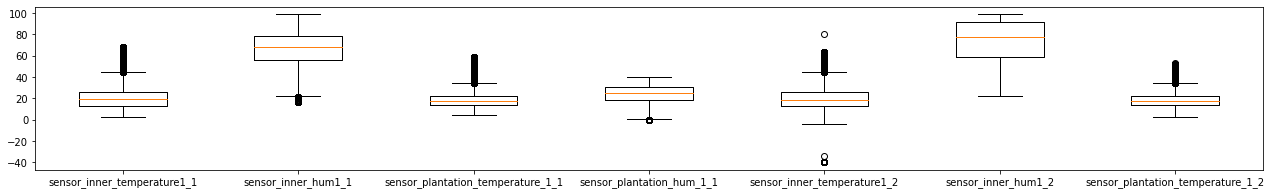

In [17]:
## 컬럼별 이상치 파악
col_list = limit_100[:7]

temp_df = train_df[col_list]
temp_df = temp_df.dropna(axis = 0)
fig, ax = plt.subplots(figsize = (22,3))
ax.boxplot([temp_df[col] for col in list(temp_df)])
plt.xticks([i for i in range(1 , len(list(temp_df)) + 1)], list(temp_df))
plt.show()

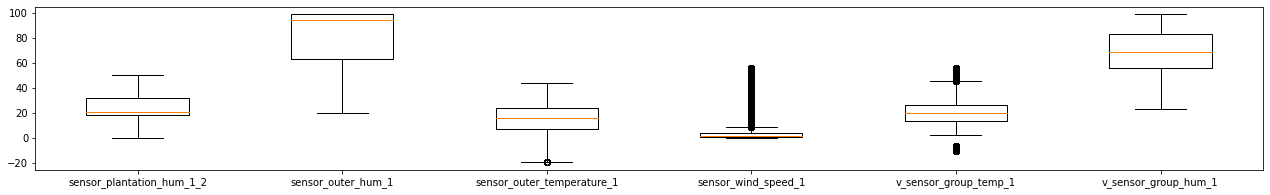

In [18]:
## 컬럼별 이상치 파악
col_list = limit_100[7:]

temp_df = train_df[col_list]
temp_df = temp_df.dropna(axis = 0)
fig, ax = plt.subplots(figsize = (22,3))
ax.boxplot([temp_df[col] for col in list(temp_df)])
plt.xticks([i for i in range(1 , len(list(temp_df)) + 1)], list(temp_df))
plt.show()

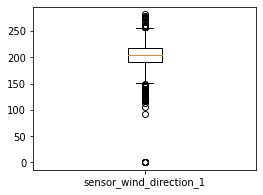

In [19]:
## 컬럼별 이상치 파악
col_list = limit_1000

temp_df = train_df[col_list]
temp_df = temp_df.dropna(axis = 0)
fig, ax = plt.subplots(figsize = (4,3))
ax.boxplot([temp_df[col] for col in list(temp_df)])
plt.xticks([i for i in range(1 , len(list(temp_df)) + 1)], list(temp_df))
plt.show()

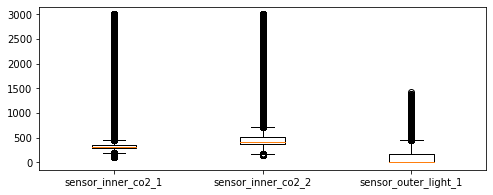

In [20]:
## 컬럼별 이상치 파악
col_list = limit_10000

temp_df = train_df[col_list]
temp_df = temp_df.dropna(axis = 0)
fig, ax = plt.subplots(figsize = (8,3))
ax.boxplot([temp_df[col] for col in list(temp_df)])
plt.xticks([i for i in range(1 , len(list(temp_df)) + 1)], list(temp_df))
plt.show()

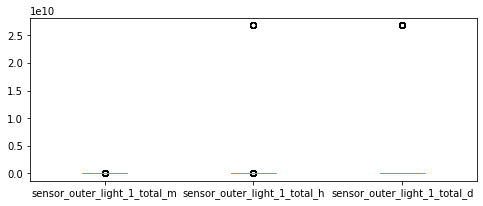

In [21]:
## 컬럼별 이상치 파악
col_list = limit_other

temp_df = train_df[col_list]
temp_df = temp_df.dropna(axis = 0)
fig, ax = plt.subplots(figsize = (8,3))
ax.boxplot([temp_df[col] for col in list(temp_df)])
plt.xticks([i for i in range(1 , len(list(temp_df)) + 1)], list(temp_df))
plt.show()

In [22]:
q3 = train_df[box_plot_col].quantile(0.75)
q1 = train_df[box_plot_col].quantile(0.25)
iqr = q3 - q1
min_value = q1 - 1.5*iqr
max_value = q3 + 1.5*iqr

temp_df = pd.DataFrame(columns = ['columns', 'outlier', 'percentile'])

for col in box_plot_col:
    print(f'{col} outlier num : {train_df[(train_df[col] < min_value[col]) | (train_df[col] > max_value[col])].shape[0]}')    
    temp_df = temp_df.append({'columns' : col,
                              'outlier' : train_df[(train_df[col] < min_value[col]) | (train_df[col] > max_value[col])].shape[0],
                              'percentile': train_df[(train_df[col] < min_value[col]) | (train_df[col] > max_value[col])].shape[0] / train_df.shape[0]},
                             ignore_index = True)
temp_df.to_csv('boxplot_outlier.csv')
outlier_df = temp_df[temp_df['outlier'] > 0]

sensor_inner_temperature1_1 outlier num : 3759
sensor_inner_hum1_1 outlier num : 277
sensor_plantation_temperature_1_1 outlier num : 5464
sensor_plantation_hum_1_1 outlier num : 20175
sensor_inner_co2_1 outlier num : 71590
sensor_inner_temperature1_2 outlier num : 11465
sensor_inner_hum1_2 outlier num : 0
sensor_plantation_temperature_1_2 outlier num : 22797
sensor_plantation_hum_1_2 outlier num : 0
sensor_inner_co2_2 outlier num : 89668
sensor_outer_light_1_total_m outlier num : 168104
sensor_outer_light_1_total_h outlier num : 106033
sensor_outer_light_1_total_d outlier num : 689
sensor_outer_light_1 outlier num : 96522
sensor_outer_hum_1 outlier num : 0
sensor_outer_temperature_1 outlier num : 0
sensor_wind_speed_1 outlier num : 46799
sensor_wind_direction_1 outlier num : 67
v_sensor_group_temp_1 outlier num : 4131
v_sensor_group_hum_1 outlier num : 0


## Check Outlier (z_score)

In [23]:
## 표준정규분포 기준 +3시그마 / -3시그마 기준에 벗어나는 데이터를 이상치로 표함
mean = train_df[box_plot_col].mean()
std = train_df[box_plot_col].std()

z_df = train_df[box_plot_col].copy()
temp_df = pd.DataFrame(columns = ['columns', 'outlier', 'percentile'])

for col in box_plot_col:
    z_df[col] = (z_df[col] - mean[col])/std[col]    
    print(f'{col} outlier num : {z_df[(z_df[col]>3) | (z_df[col]<-3)].shape[0]}')
    temp_df = temp_df.append({'columns' : col,
                              'outlier' : z_df[(z_df[col]>3) | (z_df[col]<-3)].shape[0],
                              'percentile': z_df[(z_df[col]>3) | (z_df[col]<-3)].shape[0] / train_df.shape[0]},
                             ignore_index = True)
    
temp_df = temp_df[temp_df['outlier'] > 0]
temp_df.to_csv('z_score_outlier.csv')

sensor_inner_temperature1_1 outlier num : 3810
sensor_inner_hum1_1 outlier num : 0
sensor_plantation_temperature_1_1 outlier num : 4253
sensor_plantation_hum_1_1 outlier num : 0
sensor_inner_co2_1 outlier num : 23669
sensor_inner_temperature1_2 outlier num : 8192
sensor_inner_hum1_2 outlier num : 0
sensor_plantation_temperature_1_2 outlier num : 11784
sensor_plantation_hum_1_2 outlier num : 0
sensor_inner_co2_2 outlier num : 35749
sensor_outer_light_1_total_m outlier num : 26857
sensor_outer_light_1_total_h outlier num : 32
sensor_outer_light_1_total_d outlier num : 689
sensor_outer_light_1 outlier num : 17260
sensor_outer_hum_1 outlier num : 0
sensor_outer_temperature_1 outlier num : 33
sensor_wind_speed_1 outlier num : 24025
sensor_wind_direction_1 outlier num : 193
v_sensor_group_temp_1 outlier num : 4008
v_sensor_group_hum_1 outlier num : 0


## Check Data Trend

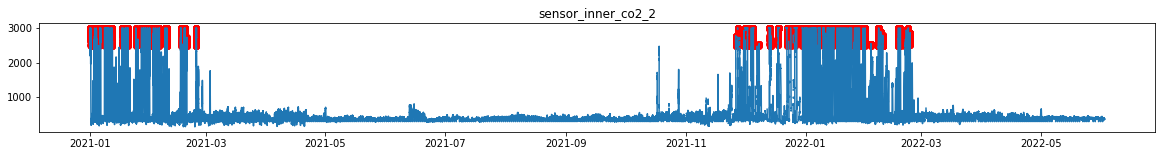

In [24]:
## boxplot 데이터 이상치 파악 추세 그래프
# for col in box_plot_col:
for col in ['sensor_inner_co2_2']:
    temp_df = train_df[[col, 'event_date_min']]
    temp_outlier = temp_df[(z_df[col]>3) | (z_df[col]<-3)]
    temp_df.set_index('event_date_min', inplace = True)
    temp_outlier.set_index('event_date_min', inplace = True)

    if temp_outlier.shape[0] > 0:
        plt.figure(figsize = (20,2))
        plt.plot(temp_df[col])
        plt.scatter(temp_outlier.index, temp_outlier, c = 'r')
        plt.title(col)
        plt.show()

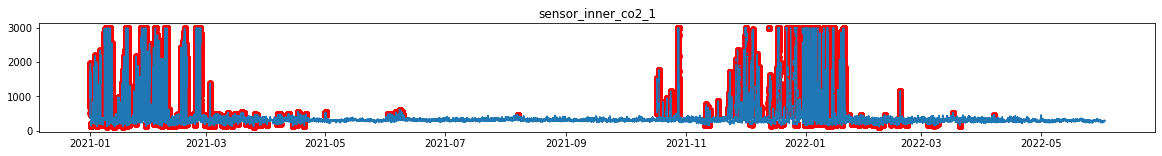

In [25]:
## z-score 데이터 이상치 파악 추세 그래프
# for col in box_plot_col:
for col in ['sensor_inner_co2_1']:
    temp_df = train_df[[col, 'event_date_min']]
    temp_df.set_index('event_date_min', inplace = True)
    temp_outlier = temp_df[(temp_df[col] < min_value[col]) | (temp_df[col] > max_value[col])]
    if temp_outlier.shape[0] > 0:
        plt.figure(figsize = (20,2))
        plt.plot(temp_df[col])
        plt.scatter(temp_outlier.index, temp_outlier, c = 'r')
        plt.title(col)
        plt.show()

In [28]:
## 데이터 일자 패턴 파악 그래프
# for col in box_plot_col:
#     temp_df = train_df[[col, 'event_date_min']][:10000]
#     temp_df.set_index('event_date_min', inplace = True)
#     plt.figure(figsize = (5,2))
#     plt.plot(temp_df[col])
#     plt.title(col)
#     plt.show()
#     input()

In [29]:
## 데이터 분포 파악 (histogram)
# for col in box_plot_col:
#     plt.figure(figsize = (5,2))
#     plt.hist(train_df[col])
#     plt.title(col)
#     plt.show()

## Heatmap

In [49]:
temp_df = train_df[box_plot_col].corr()
temp_df[[col for col in list(temp_df) if sum(abs(temp_df[col]).values > 0.7) > 2]].shape


(20, 11)

In [35]:
train_df[[col for col in list(train_df) if col not in single_col]].corr()

,day_night,top_window_1,top_window_1_run_status,top_window_1_auto_manual_mode,top_window_2,top_window_2_run_status,top_window_2_auto_manual_mode,side_window_1,side_window_1_run_status,side_window_1_auto_manual_mode,...,sensor_outer_light_1_total_m,sensor_outer_light_1_total_h,sensor_outer_light_1_total_d,sensor_outer_light_1,sensor_outer_hum_1,sensor_outer_temperature_1,sensor_wind_speed_1,sensor_wind_direction_1,v_sensor_group_temp_1,v_sensor_group_hum_1
day_night,1.000000,-0.280812,-0.020281,0.073207,-0.254825,-0.019471,0.087172,-0.055519,-0.008190,0.093015,...,-0.383336,-0.007914,0.002540,-0.570011,0.384037,-0.422733,-0.016663,0.372251,-0.533972,0.430679
top_window_1,-0.280812,1.000000,-0.008781,-0.179944,0.939537,-0.009095,-0.030350,0.023047,-0.009909,-0.295103,...,0.216146,0.011344,0.012644,0.297244,-0.248401,0.337215,-0.106973,-0.338003,0.313584,-0.274652
top_window_1_run_status,-0.020281,-0.008781,1.000000,-0.005008,-0.006354,0.993854,0.015859,-0.033707,0.806972,0.094071,...,-0.041589,-0.000799,0.001442,0.012935,-0.033676,-0.036234,-0.022441,0.036606,-0.018930,-0.042423
top_window_1_auto_manual_mode,0.073207,-0.179944,-0.005008,1.000000,-0.190609,-0.005334,0.726217,0.101642,-0.026213,0.284149,...,-0.055595,0.002111,0.010155,-0.040010,-0.053894,-0.257448,0.021449,0.197094,-0.255742,-0.041290
top_window_2,-0.254825,0.939537,-0.006354,-0.190609,1.000000,-0.005879,-0.040565,0.021454,-0.005991,-0.284529,...,0.195300,0.011396,0.013056,0.271823,-0.217488,0.373114,-0.061203,-0.364762,0.317054,-0.237793
top_window_2_run_status,-0.019471,-0.009095,0.993854,-0.005334,-0.005879,1.000000,0.015483,-0.033521,0.809255,0.094562,...,-0.041928,-0.000796,0.001474,0.012878,-0.033254,-0.035906,-0.022723,0.036022,-0.019103,-0.041897
top_window_2_auto_manual_mode,0.087172,-0.030350,0.015859,0.726217,-0.040565,0.015483,1.000000,-0.279000,-0.009959,0.185461,...,-0.132823,0.002809,0.013248,-0.060375,-0.123752,-0.443778,0.089234,0.338215,-0.456747,-0.082419
side_window_1,-0.055519,0.023047,-0.033707,0.101642,0.021454,-0.033521,-0.279000,1.000000,-0.016170,0.137888,...,0.075165,-0.002010,-0.009342,0.054682,0.034698,0.268842,-0.052993,-0.209370,0.261596,-0.003618
side_window_1_run_status,-0.008190,-0.009909,0.806972,-0.026213,-0.005991,0.809255,-0.009959,-0.016170,1.000000,0.063076,...,-0.026017,-0.000565,-0.002554,0.011606,-0.008053,0.014128,0.001731,-0.010020,0.014444,-0.007162
side_window_1_auto_manual_mode,0.093015,-0.295103,0.094071,0.284149,-0.284529,0.094562,0.185461,0.137888,0.063076,1.000000,...,-0.265431,0.005664,0.026578,-0.079526,-0.102299,-0.271045,0.073966,0.259097,-0.219710,-0.063499


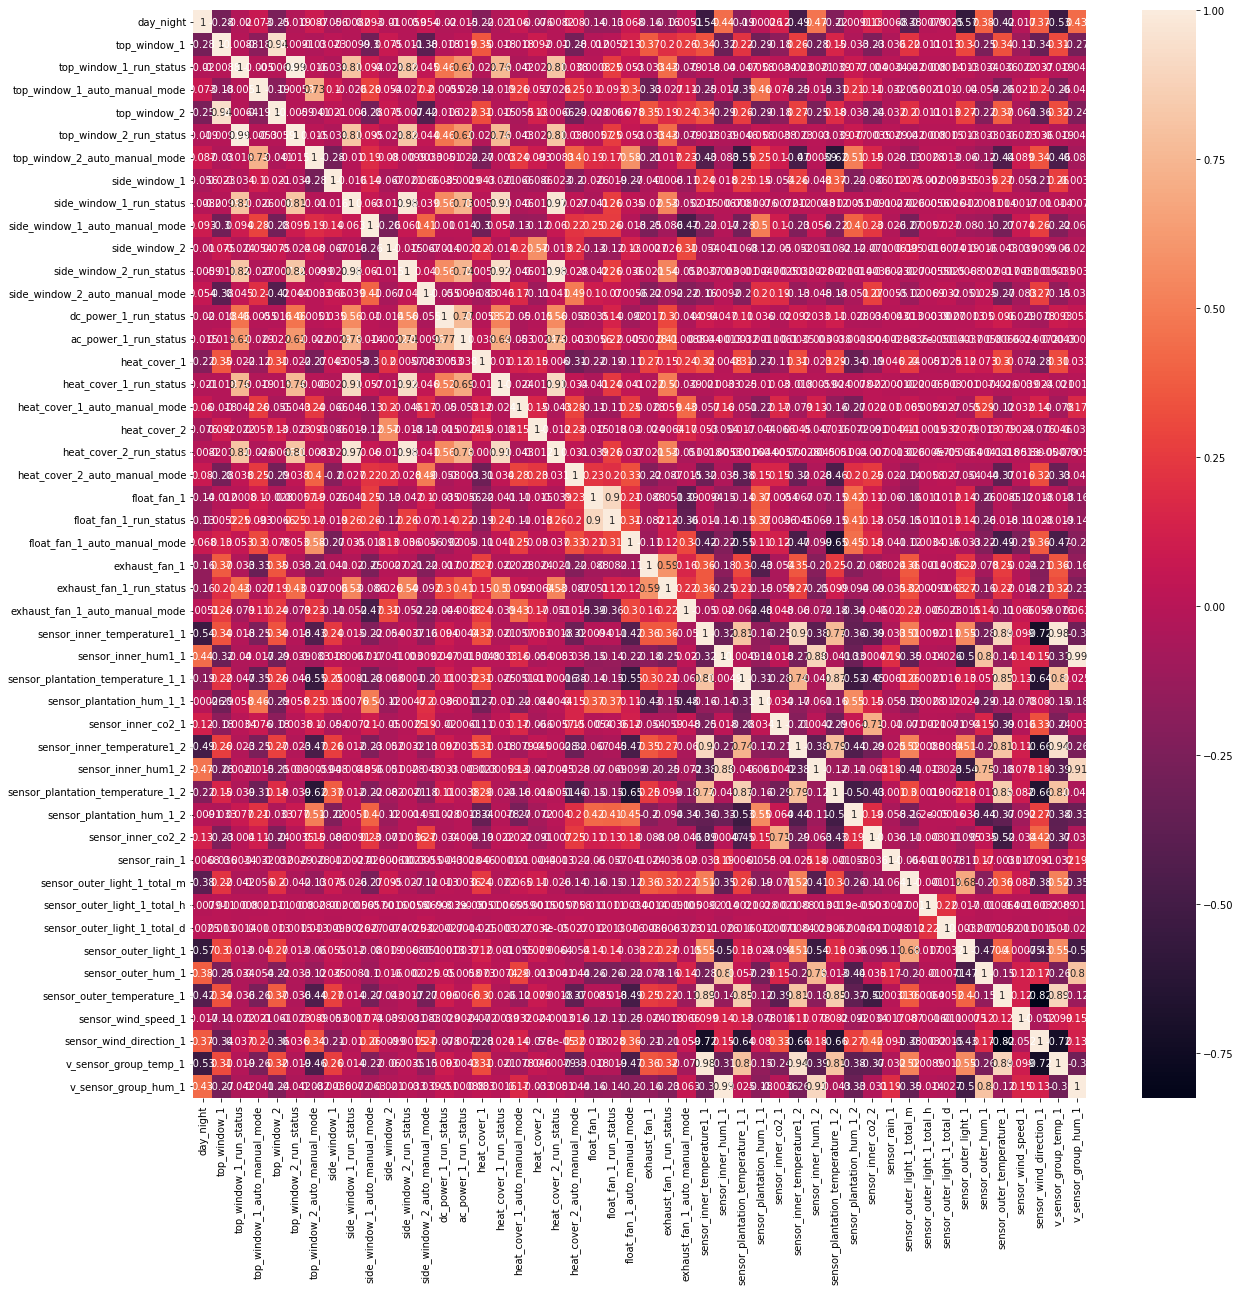

In [34]:
plt.figure(figsize = (20,20))
ax = sns.heatmap(train_df[[col for col in list(train_df) if col not in single_col]].corr(), annot = True)
plt.show() 

## Save PreProcessing Columns

In [35]:
import pickle

def save_pickle(object_name, object_):
    with open(f'{object_name}.pickle','wb') as fw:
        pickle.dump(object_, fw)
        
def read_pickle(object_name):
    with open(f'{object_name}.pickle','rb') as fr:
        object_ = pickle.load(fr)
    return object_

save_pickle('single_col', single_col)
save_pickle('box_plot_col', box_plot_col)